In [ ]:
# Install necessary libraries
!pip install sentinelhub
!pip install geopandas

from sentinelhub import SHConfig, SentinelHubRequest, DataCollection, bbox_to_dimensions, BBox, MimeType
import numpy as np
from shapely.geometry import box
import geopandas as gpd

# Configuration for Sentinel Hub API
config = SHConfig()

# Add your Sentinel Hub API credentials
config.instance_id = '00c4dbdc-e8bb-4f02-9c78-ffad9a472d60'  # Replace with your instance ID
config.sh_client_id = '00c4dbdc-e8bb-4f02-9c78-ffad9a472d60'      # Replace with your client ID
config.sh_client_secret = 'YUCO1sGz51iDP81uKlSDUT0ddbcns4wW'  # Replace with your client secret

# Ensure credentials are correctly loaded
if not config.sh_client_id or not config.sh_client_secret:
    raise ValueError("Sentinel Hub client_id and client_secret must be set. Please update the code with valid credentials.")

# Define the area of interest (AOI)
define_bbox = [-120.65, 37.53, -120.35, 37.83]  # Example AOI (min_lon, min_lat, max_lon, max_lat)
bbox = BBox(bbox=define_bbox, crs="EPSG:4326")
resolution = 10  # Resolution in meters
size = bbox_to_dimensions(bbox, resolution=resolution)

# Adjust the size to ensure it meets Sentinel Hub API constraints
max_size = 2500
size = (min(size[0], max_size), min(size[1], max_size))

# Create Sentinel Hub request to fetch imagery
request = SentinelHubRequest(
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A
        )
    ],
    responses=[
        SentinelHubRequest.output_response("default", MimeType.TIFF)
    ],
    bbox=bbox,
    size=size,
    config=config,
    evalscript="""
        // Custom evalscript for detecting anomalies
        // Output NDVI and other bands useful for hydrogen detection
        function setup() {
            return {
                input: ["B08", "B04", "B03", "B02"],
                output: { bands: 1, sampleType: "FLOAT32" }
            };
        }

        function evaluatePixel(sample) {
            let ndvi = (sample.B08 - sample.B04) / (sample.B08 + sample.B04);
            return [ndvi];
        }
    """
)

# Fetch data
response = request.get_data()

# Process the response
ndvi_data = np.array(response)[0, :, :]

# Detect anomalies in NDVI indicating potential hydrogen leaks
threshold = -0.1  # Example threshold for anomaly detection
anomalies = ndvi_data < threshold

# Print summary statistics for analysis
print("NDVI Data Summary:")
print(f"Min: {ndvi_data.min()}, Max: {ndvi_data.max()}, Mean: {ndvi_data.mean()}")
print("Anomalies Detected:", np.sum(anomalies))

# Save anomalies as a GeoTIFF or shapefile for further analysis (optional)
# Convert the bounding box and anomalies into a GeoDataFrame
geo_df = gpd.GeoDataFrame(
    geometry=[box(*define_bbox)],
    crs="EPSG:4326"
)

# Save GeoDataFrame (e.g., to a shapefile)
geo_df.to_file("detected_anomalies.shp")



  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.8/249.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.6 MB/s eta 0:00:00
  Created wheel for utm: filename=utm-0.7.0-py3-none-any.whl size=6085 sha256=6bfe7fd1c9dbf59af6a8846ba0477933b11b8536f020a99c57f03dad8fbf3fcf
  Stored in directory: /root/.cache/pip/wheels/2f/a1/c8/543df0e8f5e824c3e92a432e32deb9cd89ae686095ee8cfcbe
Successfully built utm
NDVI Data Summary:
Min: nan, Max: nan, Mean: nan
Anomalies Detected: 71646


In [2]:
# Definir el área de interés (AOI) utilizando las coordenadas de Meda
define_bbox = [-7.0, 42.3, -6.98, 42.32]  # Coordenadas aproximadas de Meda (min_lon, min_lat, max_lon, max_lat)
bbox = BBox(bbox=define_bbox, crs="EPSG:4326")
resolution = 100  # Resolución en metros
size = bbox_to_dimensions(bbox, resolution=resolution)

# Ajustar el tamaño para cumplir con las restricciones de la API de Sentinel Hub
max_size = 2500
size = (min(size[0], max_size), min(size[1], max_size))

# Crear la solicitud a Sentinel Hub para obtener las imágenes
request = SentinelHubRequest(
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A
        )
    ],
    responses=[
        SentinelHubRequest.output_response("default", MimeType.TIFF)
    ],
    bbox=bbox,
    size=size,
    config=config,
    evalscript="""
        // Evalscript personalizado para detectar anomalías
        // Calcula el NDVI y otras bandas útiles para la detección de hidrógeno
        function setup() {
            return {
                input: ["B08", "B04", "B03", "B02"],
                output: { bands: 1, sampleType: "FLOAT32" }
            };
        }

        function evaluatePixel(sample) {
            let ndvi = (sample.B08 - sample.B04) / (sample.B08 + sample.B04);
            return [ndvi];
        }
    """
)

# Obtener los datos
response = request.get_data()

# Procesar la respuesta
ndvi_data = np.array(response)[0, :, :]

# Detectar anomalías en el NDVI que indiquen posibles fugas de hidrógeno
umbral = -0.1  # Umbral de ejemplo para la detección de anomalías
anomalies = ndvi_data < umbral

# Imprimir estadísticas resumidas para el análisis
print("Resumen de datos NDVI:")
print(f"Mínimo: {ndvi_data.min()}, Máximo: {ndvi_data.max()}, Media: {ndvi_data.mean()}")
print("Anomalías detectadas:", np.sum(anomalies))

# Guardar las anomalías como un shapefile para análisis posterior (opcional)
# Convertir el bounding box y las anomalías en un GeoDataFrame
geo_df = gpd.GeoDataFrame(
    geometry=[box(*define_bbox)],
    crs="EPSG:4326"
)

# Guardar el GeoDataFrame (por ejemplo, en un shapefile)
geo_df.to_file("anomalías_detectadas.shp")

Resumen de datos NDVI:
Mínimo: -1.0, Máximo: 0.9327309131622314, Media: 0.6920126080513
Anomalías detectadas: 1


NDVI Data Summary:
Min: -1.0, Max: 0.9327309131622314, Mean: 0.6920126080513
Anomalies Detected: 1


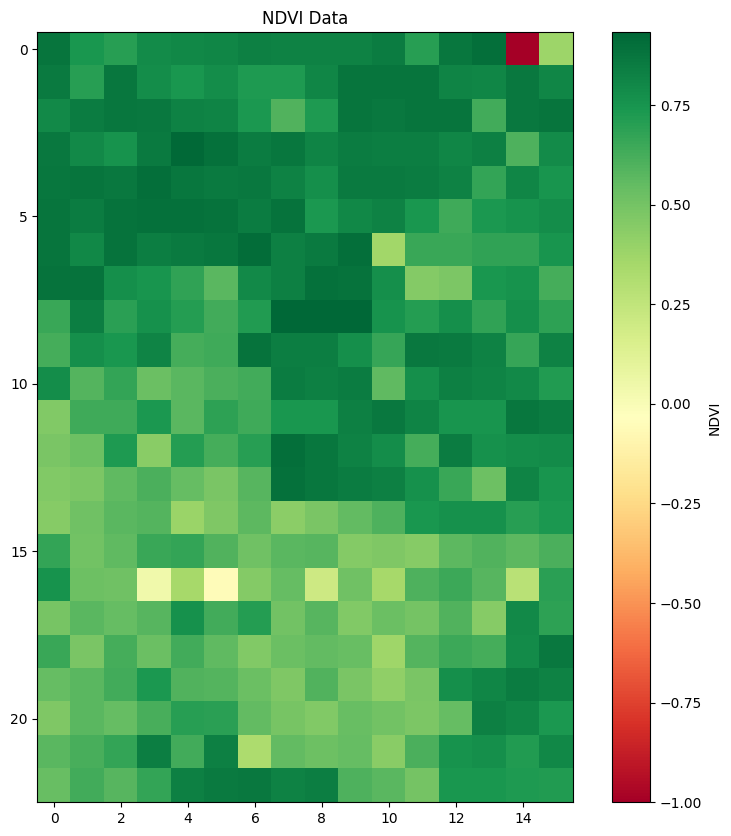

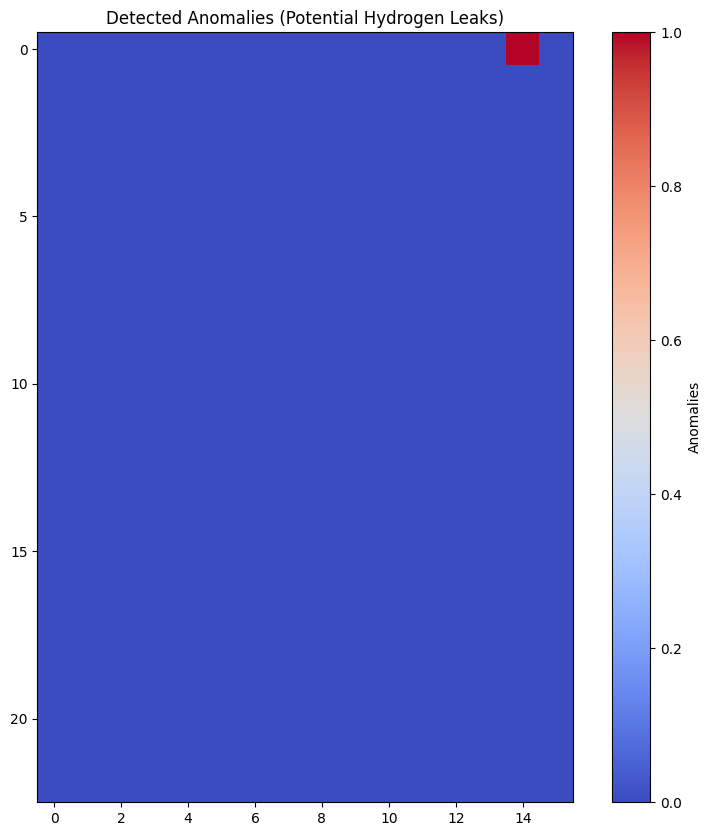

In [3]:
import matplotlib.pyplot as plt


# Print summary statistics for analysis
print("NDVI Data Summary:")
print(f"Min: {ndvi_data.min()}, Max: {ndvi_data.max()}, Mean: {ndvi_data.mean()}")
print("Anomalies Detected:", np.sum(anomalies))

# Visualize NDVI data
plt.figure(figsize=(10, 10))
plt.title("NDVI Data")
plt.imshow(ndvi_data, cmap='RdYlGn')
plt.colorbar(label='NDVI')
plt.show()

# Visualize anomalies
plt.figure(figsize=(10, 10))
plt.title("Detected Anomalies (Potential Hydrogen Leaks)")
plt.imshow(anomalies, cmap='coolwarm')
plt.colorbar(label='Anomalies')
plt.show()

# Save anomalies as a GeoTIFF or shapefile for further analysis (optional)
# Convert the bounding box and anomalies into a GeoDataFrame
geo_df = gpd.GeoDataFrame(
    geometry=[box(*define_bbox)],
    crs="EPSG:4326"
)

# Save GeoDataFrame (e.g., to a shapefile)
geo_df.to_file("detected_anomalies.shp")

NDVI Data Summary:
Min: -0.06726013869047165, Max: 0.980246901512146, Mean: 0.10685120522975922
Anomalies Detected: 0


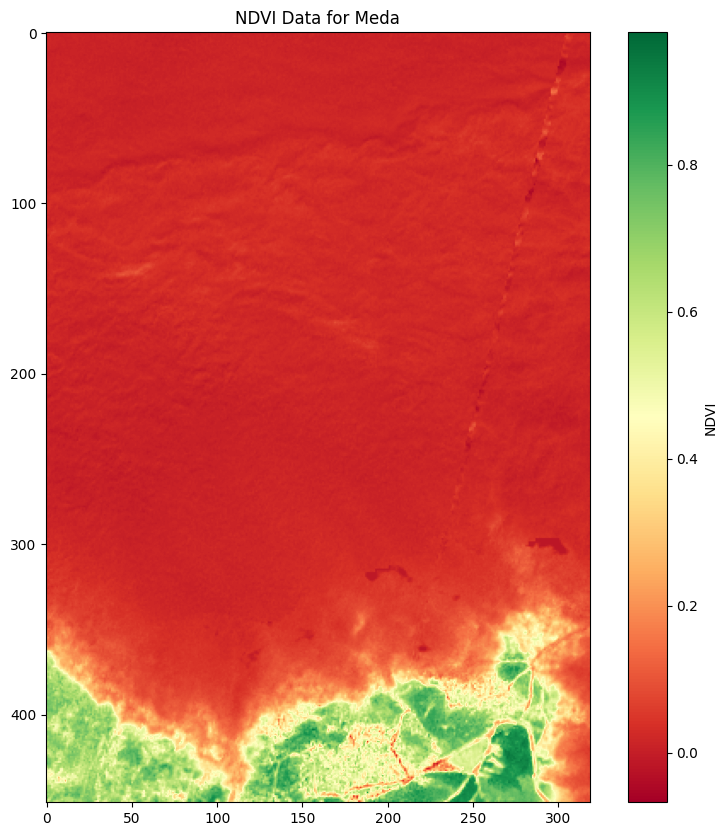

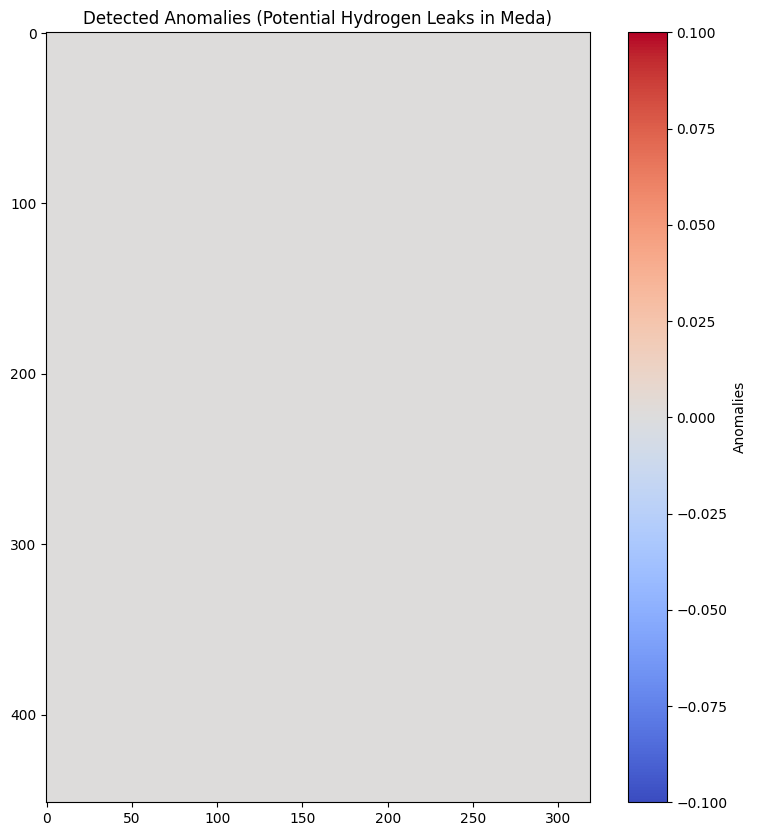

In [4]:

from sentinelhub import SHConfig, SentinelHubRequest, DataCollection, bbox_to_dimensions, BBox, MimeType
import numpy as np
from shapely.geometry import box
import geopandas as gpd
from matplotlib import pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.geometry import box, Point

# Configuration for Sentinel Hub API
config = SHConfig()

# Add your Sentinel Hub API credentials
config.instance_id = '00c4dbdc-e8bb-4f02-9c78-ffad9a472d60'  # Replace with your instance ID
config.sh_client_id = '00c4dbdc-e8bb-4f02-9c78-ffad9a472d60'      # Replace with your client ID
config.sh_client_secret = 'YUCO1sGz51iDP81uKlSDUT0ddbcns4wW'  # Replace with your client secret


# Define the area of interest (AOI) for Meda, A Veiga, Ourense, Galicia
define_bbox = [-7.04, 42.38, -7.00, 42.42]  # Coordinates for Meda (min_lon, min_lat, max_lon, max_lat)
bbox = BBox(bbox=define_bbox, crs="EPSG:4326")
resolution = 10  # Resolution in meters
size = bbox_to_dimensions(bbox, resolution=resolution)

# Adjust the size to ensure it meets Sentinel Hub API constraints
max_size = 2500
size = (min(size[0], max_size), min(size[1], max_size))

# Create Sentinel Hub request to fetch imagery
request = SentinelHubRequest(
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A
        )
    ],
    responses=[
        SentinelHubRequest.output_response("default", MimeType.TIFF)
    ],
    bbox=bbox,
    size=size,
    config=config,
    evalscript="""
        // Custom evalscript for detecting anomalies
        // Output NDVI and other bands useful for hydrogen detection
        function setup() {
            return {
                input: ["B08", "B04", "B03", "B02"],
                output: { bands: 1, sampleType: "FLOAT32" }
            };
        }

        function evaluatePixel(sample) {
            let ndvi = (sample.B08 - sample.B04) / (sample.B08 + sample.B04);
            return [ndvi];
        }
    """
)

# Fetch data
response = request.get_data()

# Process the response
ndvi_data = np.array(response)[0, :, :]

# Detect anomalies in NDVI indicating potential hydrogen leaks
threshold = -0.1  # Example threshold for anomaly detection
anomalies = ndvi_data < threshold

## Find coordinates of anomalies
height, width = ndvi_data.shape
lon_min, lat_min, lon_max, lat_max = bbox.lower_left[0], bbox.lower_left[1], bbox.upper_right[0], bbox.upper_right[1]
lon_range = np.linspace(lon_min, lon_max, width)
lat_range = np.linspace(lat_max, lat_min, height)

anomaly_coords = []
for y, row in enumerate(anomalies):
    for x, is_anomaly in enumerate(row):
        if is_anomaly:
            anomaly_coords.append((lon_range[x], lat_range[y]))

# Print summary statistics for analysis
print("NDVI Data Summary:")
print(f"Min: {ndvi_data.min()}, Max: {ndvi_data.max()}, Mean: {ndvi_data.mean()}")
print("Anomalies Detected:", len(anomaly_coords))

# Visualize NDVI data
plt.figure(figsize=(10, 10))
plt.title("NDVI Data for Meda")
plt.imshow(ndvi_data, cmap='RdYlGn')
plt.colorbar(label='NDVI')
plt.show()

# Visualize anomalies
plt.figure(figsize=(10, 10))
plt.title("Detected Anomalies (Potential Hydrogen Leaks in Meda)")
plt.imshow(anomalies, cmap='coolwarm')
plt.colorbar(label='Anomalies')

# Plot anomaly coordinates
for coord in anomaly_coords:
    x_idx = np.where(lon_range == coord[0])[0][0]
    y_idx = np.where(lat_range == coord[1])[0][0]
    plt.plot(x_idx, y_idx, 'ro')  # Mark anomalies in red
plt.show()

# Save anomalies as a GeoDataFrame
geo_df = gpd.GeoDataFrame(
    geometry=[Point(lon, lat) for lon, lat in anomaly_coords],
    crs="EPSG:4326"
)

# Save GeoDataFrame (e.g., to a shapefile)
geo_df.to_file("anomaly_points_meda.shp")

In [5]:
# Install necessary libraries
!pip install sentinelhub
!pip install geopandas

from sentinelhub import SHConfig, SentinelHubRequest, DataCollection, bbox_to_dimensions, BBox, MimeType
import numpy as np
from shapely.geometry import box
import geopandas as gpd

# Configuration for Sentinel Hub API
config = SHConfig()

# Add your Sentinel Hub API credentials
config.instance_id = '00c4dbdc-e8bb-4f02-9c78-ffad9a472d60'  # Replace with your instance ID
config.sh_client_id = '00c4dbdc-e8bb-4f02-9c78-ffad9a472d60'      # Replace with your client ID
config.sh_client_secret = 'YUCO1sGz51iDP81uKlSDUT0ddbcns4wW'  # Replace with your client secret

Hyperspectral Data Summary:
Min: 0.20884248614311218, Max: 0.719047486782074, Mean: 0.5348654985427856
Anomalies Detected: 6


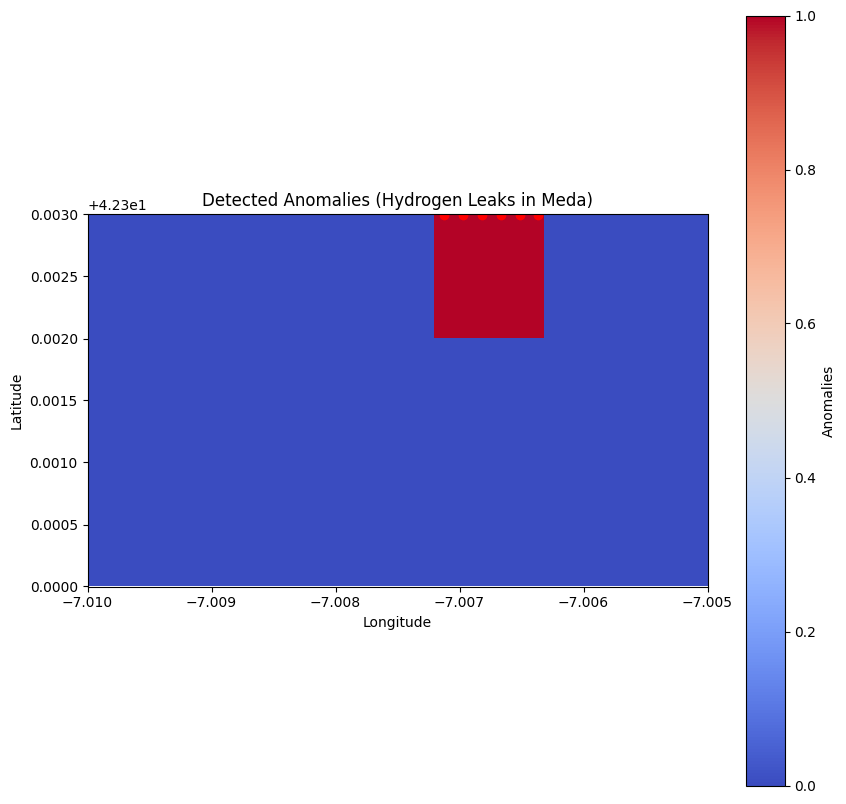

In [55]:
# Define the area of interest (AOI) for Meda, A Veiga, Ourense, Galicia
# Coordinates for Meda (min_lon, min_lat, max_lon, max_lat)
#define_bbox = [-7.010, 42.295, -7.005, 42.300]   # Coordinates for Meda (min_lon, min_lat, max_lon, max_lat)


# Define bounding box for Prada
#define_bbox = [-7.018, 42.316, -7.016, 42.318]

# Define bounding box for Candeda
#define_bbox = [-7.018, 42.282, -7.016, 42.284]

# Define bounding box for Curra
#define_bbox = [-7.018, 42.282, -7.016, 42.284]

# Define bounding box for a portela
define_bbox = [-7.0100, 42.3000, -7.0050, 42.3030]



bbox = BBox(bbox=define_bbox, crs="EPSG:4326")
resolution = 10  # Resolution in meters
size = bbox_to_dimensions(bbox, resolution=resolution)

# Adjust the size to ensure it meets Sentinel Hub API constraints
max_size = 2500
size = (min(size[0], max_size), min(size[1], max_size))

# Create Sentinel Hub request to fetch imagery
request = SentinelHubRequest(
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A
        )
    ],
    responses=[
        SentinelHubRequest.output_response("default", MimeType.TIFF)
    ],
    bbox=bbox,
    size=size,
    config=config,
    evalscript="""
        // Custom evalscript for hyperspectral analysis
        // Output all bands useful for hydrogen detection
        function setup() {
            return {
                input: ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B11", "B12"],
                output: { bands: 12, sampleType: "FLOAT32" }
            };
        }

        function evaluatePixel(sample) {
            return [
                sample.B01, sample.B02, sample.B03, sample.B04, sample.B05, sample.B06,
                sample.B07, sample.B08, sample.B8A, sample.B09, sample.B11, sample.B12
            ];
        }
    """
)

# Fetch data
response = request.get_data()

# Process the response (hyperspectral bands)
data = np.array(response)
hydrogen_anomalies = np.mean(data[0, :, :, [8, 9, 10]], axis=-1)  # Example using bands 8A, 9, 11
threshold = np.percentile(hydrogen_anomalies, 95)  # Top 5% anomalies
anomalies = hydrogen_anomalies > threshold

# Find coordinates of anomalies
height, width = hydrogen_anomalies.shape
lat_min, lat_max = bbox.lower_left[1], bbox.upper_right[1]
lon_min, lon_max = bbox.lower_left[0], bbox.upper_right[0]

lat_coords = np.linspace(lat_max, lat_min, height)
lon_coords = np.linspace(lon_min, lon_max, width)

anomaly_coords = [(lon_coords[x], lat_coords[y]) for y, x in zip(*np.where(anomalies))]

# Print summary statistics for analysis
print("Hyperspectral Data Summary:")
print(f"Min: {hydrogen_anomalies.min()}, Max: {hydrogen_anomalies.max()}, Mean: {hydrogen_anomalies.mean()}")
print("Anomalies Detected:", len(anomaly_coords))

# Visualize hyperspectral anomalies
plt.figure(figsize=(10, 10))
plt.title("Detected Anomalies (Hydrogen Leaks in Meda)")
plt.imshow(anomalies, cmap='coolwarm', extent=[lon_min, lon_max, lat_min, lat_max])
plt.colorbar(label='Anomalies')

# Plot anomaly coordinates
for lon, lat in anomaly_coords:
    plt.plot(lon, lat, 'ro')  # Mark anomalies in red
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# Save anomalies as a GeoDataFrame
geo_df = gpd.GeoDataFrame(
    geometry=[Point(lon, lat) for lon, lat in anomaly_coords],
    crs="EPSG:4326"
)

# Save GeoDataFrame (e.g., to a shapefile)
geo_df.to_file("hyperspectral_anomaly_points_meda.shp")

In [56]:
import folium

In [57]:
# Plot anomalies on a map with a satellite base layer
m = folium.Map(location=[(lat_min + lat_max) / 2, (lon_min + lon_max) / 2], zoom_start=14)

# Add anomaly points to the map
for lon, lat in anomaly_coords:
    folium.Marker([lat, lon], popup="Anomaly Detected", icon=folium.Icon(color='red')).add_to(m)

# Display the map
m.save("anomalies_map.html")
print("Map saved as anomalies_map.html")

Map saved as anomalies_map.html


Detailed report saved as anomaly_report.csv
Hyperspectral Data Summary:
Min: 0.20884248614311218, Max: 0.719047486782074, Mean: 0.5348654985427856
High Confidence Anomalies Detected: 3
Medium Confidence Anomalies Detected: 8


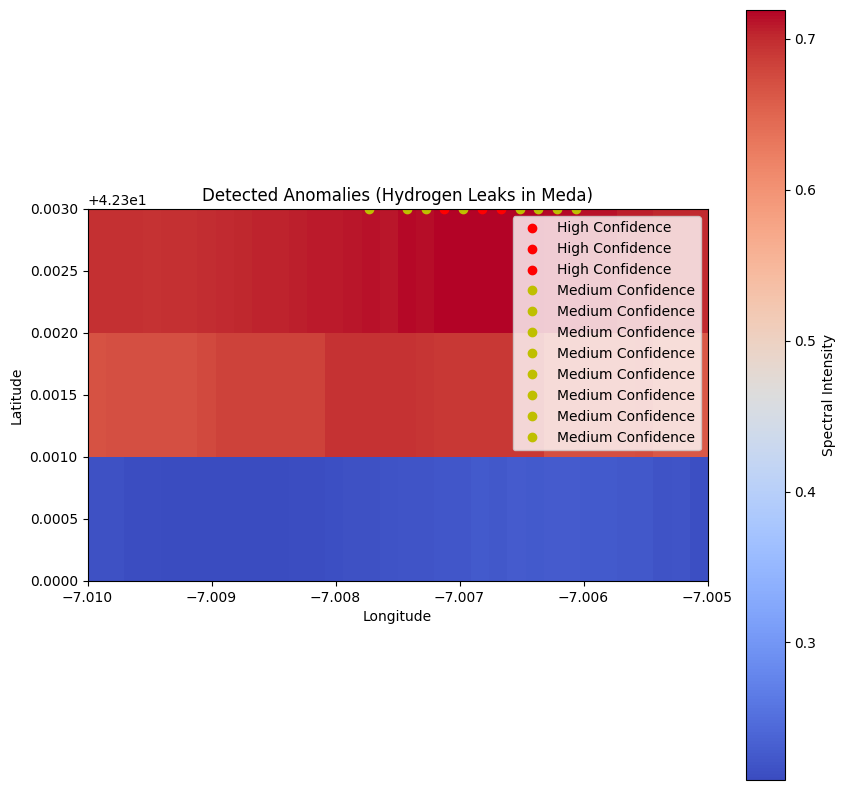

Map saved as anomalies_map.html


<ipython-input-58-919ec6d89f74>:137: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  geo_df.to_file("hyperspectral_anomaly_points_meda.shp")
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Confidence Level' to 'Confidence'
  ogr_write(


In [58]:
# Install necessary libraries
!pip install sentinelhub
!pip install geopandas
!pip install matplotlib
!pip install pandas

from sentinelhub import SHConfig, SentinelHubRequest, DataCollection, bbox_to_dimensions, BBox, MimeType
import numpy as np
from shapely.geometry import box, Point
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
import pandas as pd

# Configuration for Sentinel Hub API
config = SHConfig()

# Add your Sentinel Hub API credentials
config.instance_id = '00c4dbdc-e8bb-4f02-9c78-ffad9a472d60'  # Replace with your instance ID
config.sh_client_id = '00c4dbdc-e8bb-4f02-9c78-ffad9a472d60'      # Replace with your client ID
config.sh_client_secret = 'YUCO1sGz51iDP81uKlSDUT0ddbcns4wW'  # Replace with your client secret



# Define the area of interest (AOI) for Meda, A Veiga, Ourense, Galicia
#define_bbox = [-7.010, 42.295, -7.005, 42.300]  # Coordinates for Meda (min_lon, min_lat, max_lon, max_lat)
# coords from meda to prada
#define_bbox = [-7.018, 42.295, -7.005, 42.318]
# from meda to candeda
#define_bbox = [-7.020, 42.280, -7.005, 42.300]
# from meda to curra
#define_bbox = [-7.025, 42.280, -7.005, 42.300]
# from a portela
define_bbox = [-7.0100, 42.3000, -7.0050, 42.3030]

bbox = BBox(bbox=define_bbox, crs="EPSG:4326")
resolution = 10  # Resolution in meters
size = bbox_to_dimensions(bbox, resolution=resolution)

# Adjust the size to ensure it meets Sentinel Hub API constraints
max_size = 2500
size = (min(size[0], max_size), min(size[1], max_size))

# Create Sentinel Hub request to fetch imagery
request = SentinelHubRequest(
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A
        )
    ],
    responses=[
        SentinelHubRequest.output_response("default", MimeType.TIFF)
    ],
    bbox=bbox,
    size=size,
    config=config,
    evalscript="""
        // Custom evalscript for hyperspectral analysis
        // Output all bands useful for hydrogen detection
        function setup() {
            return {
                input: ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B11", "B12"],
                output: { bands: 12, sampleType: "FLOAT32" }
            };
        }

        function evaluatePixel(sample) {
            return [
                sample.B01, sample.B02, sample.B03, sample.B04, sample.B05, sample.B06,
                sample.B07, sample.B08, sample.B8A, sample.B09, sample.B11, sample.B12
            ];
        }
    """
)

# Fetch data
response = request.get_data()

# Process the response (hyperspectral bands)
data = np.array(response)
hydrogen_anomalies = np.mean(data[0, :, :, [8, 9, 10]], axis=-1)  # Example using bands 8A, 9, 11

# Define multiple thresholds for classification
threshold_high = np.percentile(hydrogen_anomalies, 97.5)  # Top 2.5%
threshold_medium = np.percentile(hydrogen_anomalies, 90)  # Top 10%
anomalies_high = hydrogen_anomalies > threshold_high
anomalies_medium = (hydrogen_anomalies > threshold_medium) & (~anomalies_high)

# Find coordinates of anomalies
height, width = hydrogen_anomalies.shape
lat_min, lat_max = bbox.lower_left[1], bbox.upper_right[1]
lon_min, lon_max = bbox.lower_left[0], bbox.upper_right[0]

lat_coords = np.linspace(lat_max, lat_min, height)
lon_coords = np.linspace(lon_min, lon_max, width)

anomaly_coords_high = [(lon_coords[x], lat_coords[y], "High Confidence") for y, x in zip(*np.where(anomalies_high))]
anomaly_coords_medium = [(lon_coords[x], lat_coords[y], "Medium Confidence") for y, x in zip(*np.where(anomalies_medium))]

anomaly_coords = anomaly_coords_high + anomaly_coords_medium

# Export detailed report
df = pd.DataFrame(anomaly_coords, columns=["Longitude", "Latitude", "Confidence Level"])
df.to_csv("anomaly_report.csv", index=False)
print("Detailed report saved as anomaly_report.csv")

# Print summary statistics for analysis
print("Hyperspectral Data Summary:")
print(f"Min: {hydrogen_anomalies.min()}, Max: {hydrogen_anomalies.max()}, Mean: {hydrogen_anomalies.mean()}")
print("High Confidence Anomalies Detected:", len(anomaly_coords_high))
print("Medium Confidence Anomalies Detected:", len(anomaly_coords_medium))

# Visualize hyperspectral anomalies
plt.figure(figsize=(10, 10))
plt.title("Detected Anomalies (Hydrogen Leaks in Meda)")
plt.imshow(hydrogen_anomalies, cmap='coolwarm', extent=[lon_min, lon_max, lat_min, lat_max])
plt.colorbar(label='Spectral Intensity')

# Plot anomaly coordinates
for lon, lat, confidence in anomaly_coords_high:
    plt.plot(lon, lat, 'ro', label='High Confidence' if confidence == "High Confidence" else None)
for lon, lat, confidence in anomaly_coords_medium:
    plt.plot(lon, lat, 'yo', label='Medium Confidence' if confidence == "Medium Confidence" else None)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()

# Save anomalies as a GeoDataFrame
geo_df = gpd.GeoDataFrame(
    geometry=[Point(lon, lat) for lon, lat, _ in anomaly_coords],
    data={"Confidence Level": [confidence for _, _, confidence in anomaly_coords]},
    crs="EPSG:4326"
)

# Save GeoDataFrame (e.g., to a shapefile)
geo_df.to_file("hyperspectral_anomaly_points_meda.shp")

# Plot anomalies on a map with a satellite base layer
m = folium.Map(location=[(lat_min + lat_max) / 2, (lon_min + lon_max) / 2], zoom_start=14)

# Add anomaly points to the map
for lon, lat, confidence in anomaly_coords:
    color = 'red' if confidence == "High Confidence" else 'orange'
    folium.Marker([lat, lon], popup=f"Anomaly ({confidence})", icon=folium.Icon(color=color)).add_to(m)

# Display the map
m.save("anomalies_map.html")
print("Map saved as anomalies_map.html")


Detailed report saved as anomaly_report.csv
Hyperspectral Data Summary:
NDVI Min: -0.03393663465976715, NDVI Max: 0.013927563093602657, NDVI Mean: -0.008805593475699425
High Confidence Anomalies Detected: 14
Clustered Anomalies Detected: 0


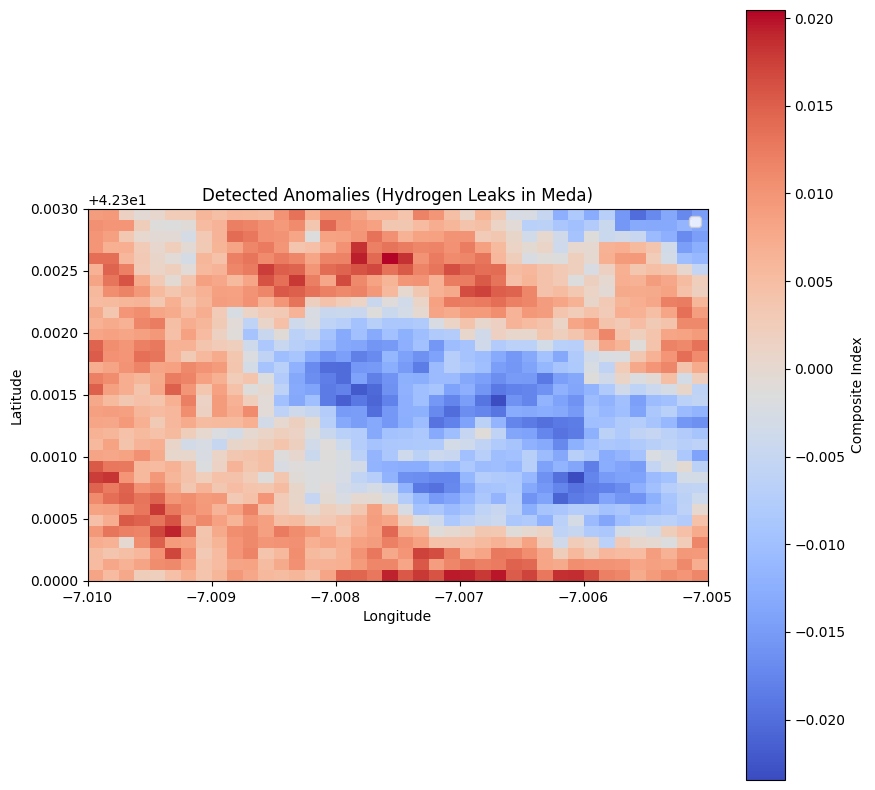

Map saved as anomalies_map.html


<ipython-input-61-18c42d7463e0>:148: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  geo_df.to_file("hyperspectral_anomaly_points_meda.shp")
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Confidence Level' to 'Confidence'
  ogr_write(


In [61]:


from sentinelhub import SHConfig, SentinelHubRequest, DataCollection, bbox_to_dimensions, BBox, MimeType
import numpy as np
from shapely.geometry import box, Point
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN



# Define the area of interest (AOI) for Meda, A Veiga, Ourense, Galicia
#define_bbox = [-7.025, 42.280, -7.005, 42.300]  # Coordinates for Meda (min_lon, min_lat, max_lon, max_lat)
#define_bbox = [-7.018, 42.295, -7.005, 42.318]
#define_bbox = [-7.020, 42.280, -7.005, 42.300]
#define_bbox = [-7.025, 42.280, -7.005, 42.300]
# from a portela
define_bbox = [-7.0100, 42.3000, -7.0050, 42.3030]


bbox = BBox(bbox=define_bbox, crs="EPSG:4326")
resolution = 10  # Resolution in meters
size = bbox_to_dimensions(bbox, resolution=resolution)

# Adjust the size to ensure it meets Sentinel Hub API constraints
max_size = 2500
size = (min(size[0], max_size), min(size[1], max_size))

# Create Sentinel Hub request to fetch imagery
request = SentinelHubRequest(
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A
        )
    ],
    responses=[
        SentinelHubRequest.output_response("default", MimeType.TIFF)
    ],
    bbox=bbox,
    size=size,
    config=config,
    evalscript="""
        // Custom evalscript for hyperspectral analysis
        // Output all bands useful for hydrogen detection
        function setup() {
            return {
                input: ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B11", "B12"],
                output: { bands: 12, sampleType: "FLOAT32" }
            };
        }

        function evaluatePixel(sample) {
            return [
                sample.B01, sample.B02, sample.B03, sample.B04, sample.B05, sample.B06,
                sample.B07, sample.B08, sample.B8A, sample.B09, sample.B11, sample.B12
            ];
        }
    """
)

# Fetch data
response = request.get_data()

# Process the response (hyperspectral bands)
data = np.array(response)

# Calculate multiple spectral indices
ndvi = (data[0, :, :, 7] - data[0, :, :, 3]) / (data[0, :, :, 7] + data[0, :, :, 3])  # NDVI
ndwi = (data[0, :, :, 2] - data[0, :, :, 8]) / (data[0, :, :, 2] + data[0, :, :, 8])  # NDWI
savi = ((data[0, :, :, 7] - data[0, :, :, 3]) / (data[0, :, :, 7] + data[0, :, :, 3] + 0.5)) * 1.5  # SAVI
composite_index = (ndvi + ndwi + savi) / 3  # Combine indices for anomaly detection

# Thresholding to detect anomalies
threshold_high = np.percentile(composite_index, 99)  # Top 2.5%
anomalies_high = composite_index > threshold_high

# Cluster anomalies to identify concentrated areas
anomaly_coords = np.column_stack(np.where(anomalies_high))
clustering = DBSCAN(eps=5, min_samples=10).fit(anomaly_coords)
cluster_labels = clustering.labels_

# Filter clusters
filtered_clusters = np.unique(cluster_labels[cluster_labels != -1])
clustered_anomalies = []
for cluster in filtered_clusters:
    cluster_points = anomaly_coords[cluster_labels == cluster]
    cluster_center = cluster_points.mean(axis=0)
    # Ensure the index is within bounds
    lon_index = int(cluster_center[1])
    lat_index = int(cluster_center[0])

    lon_index = min(lon_index, len(lon_coords) - 1) # Cap index to within size of lon_coords
    lat_index = min(lat_index, len(lat_coords) - 1) # Cap index to within size of lat_coords

    clustered_anomalies.append((
        lon_coords[lon_index],
        lat_coords[lat_index],
        "Clustered High Confidence"
    ))

# Find coordinates of anomalies
height, width = composite_index.shape
lat_min, lat_max = bbox.lower_left[1], bbox.upper_right[1]
lon_min, lon_max = bbox.lower_left[0], bbox.upper_right[0]

lat_coords = np.linspace(lat_max, lat_min, height)
lon_coords = np.linspace(lon_min, lon_max, width)

anomaly_coords_high = [(lon_coords[x], lat_coords[y], "High Confidence") for y, x in zip(*np.where(anomalies_high))]
anomaly_coords = anomaly_coords_high + clustered_anomalies

# Export detailed report
df = pd.DataFrame(anomaly_coords, columns=["Longitude", "Latitude", "Confidence Level"])
df.to_csv("anomaly_report.csv", index=False)
print("Detailed report saved as anomaly_report.csv")

# Print summary statistics for analysis
print("Hyperspectral Data Summary:")
print(f"NDVI Min: {ndvi.min()}, NDVI Max: {ndvi.max()}, NDVI Mean: {ndvi.mean()}")
print("High Confidence Anomalies Detected:", len(anomaly_coords_high))
print("Clustered Anomalies Detected:", len(clustered_anomalies))

# Visualize hyperspectral anomalies
plt.figure(figsize=(10, 10))
plt.title("Detected Anomalies (Hydrogen Leaks in Meda)")
plt.imshow(composite_index, cmap='coolwarm', extent=[lon_min, lon_max, lat_min, lat_max])
plt.colorbar(label='Composite Index')

# Plot anomaly coordinates
#for lon, lat, confidence in anomaly_coords_high:
    #plt.plot(lon, lat, 'ro', label='High Confidence' if confidence == "High Confidence" else None)
for lon, lat, confidence in clustered_anomalies:
    plt.plot(lon, lat, 'go', label='Clustered High Confidence')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()

# Save anomalies as a GeoDataFrame
geo_df = gpd.GeoDataFrame(
    geometry=[Point(lon, lat) for lon, lat, _ in anomaly_coords],
    data={"Confidence Level": [confidence for _, _, confidence in anomaly_coords]},
    crs="EPSG:4326"
)

# Save GeoDataFrame (e.g., to a shapefile)
geo_df.to_file("hyperspectral_anomaly_points_meda.shp")

# Plot anomalies on a map with a satellite base layer
m = folium.Map(location=[(lat_min + lat_max) / 2, (lon_min + lon_max) / 2], zoom_start=14)

# Add anomaly points to the map
for lon, lat, confidence in anomaly_coords:
  if confidence == "High Confidence":
    color = 'red'
    folium.Marker([lat, lon], popup=f"Anomaly ({confidence})", icon=folium.Icon(color=color)).add_to(m)

# Display the map
m.save("anomalies_map.html")
print("Map saved as anomalies_map.html")


In [64]:
# Additional Analysis for Precious Mineral Indicators
# Calculate Clay Mineral Ratio (CMR) and Ferrous Iron Ratio (FIR)
cmr = data[0, :, :, 10] / data[0, :, :, 11]  # Band 11 / Band 12
fir = (data[0, :, :, 10] - data[0, :, :, 3]) / (data[0, :, :, 10] + data[0, :, :, 3])  # (Band 11 - Band 4) / (Band 11 + Band 4)

# Threshold for CMR and FIR to indicate alteration zones
cmr_threshold = np.percentile(cmr, 90)  # Top 1%
fir_threshold = np.percentile(fir, 90)  # Top 1%

cmr_anomalies = cmr > cmr_threshold
fir_anomalies = fir > fir_threshold

# Find intersecting anomalies (regions matching both CMR and FIR criteria)
alteration_anomalies = cmr_anomalies & fir_anomalies

# Extract coordinates for alteration anomalies
alteration_coords = [(lon_coords[x], lat_coords[y]) for y, x in zip(*np.where(alteration_anomalies))]

# Add detected mineral-related anomalies to the map
for lon, lat in alteration_coords:
    folium.Marker([lat, lon], popup="Potential Mineral Alteration Zone", icon=folium.Icon(color='blue')).add_to(m)

# Save updated map
m.save("mineral_anomalies_map.html")
print("Map with mineral anomalies saved as mineral_anomalies_map.html")

# Print summary for mineral-related analysis
print("Mineral Anomalies Summary:")
print("Total Potential Mineral Alteration Zones Detected:", len(alteration_coords))



Map with mineral anomalies saved as mineral_anomalies_map.html
Mineral Anomalies Summary:
Total Potential Mineral Alteration Zones Detected: 11
